1. a

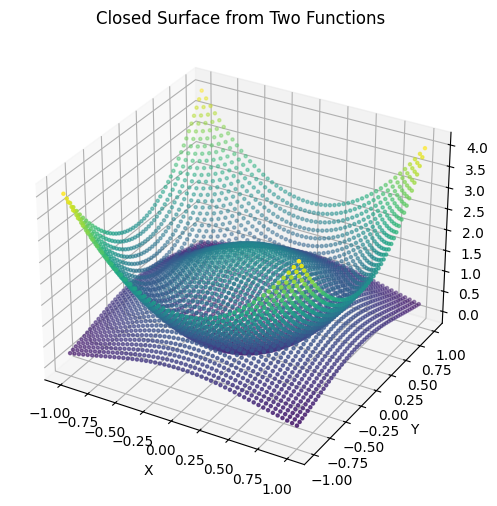

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def surface1(x, y):
    """
    surface1(x,y) = 2x^2 + 2y^2
    """
    return 2*x**2 + 2*y**2

def surface2(x, y):
    """
    surface2(x,y) = 2 e^(-x^2 - y^2)
    """
    return 2 * np.exp(-x**2 - y**2)

def generate_closed_surface_points(n=50):
   
    x_vals = np.linspace(-1, 1, n)
    y_vals = np.linspace(-1, 1, n)
    
    point_list = []
    for x in x_vals:
        for y in y_vals:
            z1 = surface1(x, y)
            z2 = surface2(x, y)
            # One point on surface1, one on surface2
            point_list.append([x, y, z1])
            point_list.append([x, y, z2])
    
    return np.array(point_list)

def main():
    # 1) Generate the point cloud
    points = generate_closed_surface_points(n=50)

    # 2) Plot in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               s=5, c=points[:, 2], cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Closed Surface from Two Functions')
    plt.show()

if __name__ == "__main__":
    main()


1. b

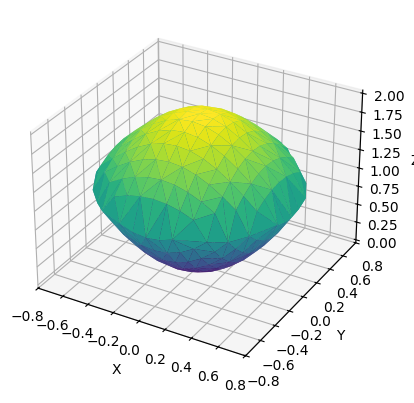

In [8]:
#!/usr/bin/env python

from collections import Counter
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def triangle_area(xs, ys):
    ax = xs[1] - xs[0]
    ay = ys[1] - ys[0]
    bx = xs[2] - xs[0]
    by = ys[2] - ys[0]
    cross_val = ax * by - ay * bx
    return abs(cross_val) / 2.0

def surface1(x, y):
    return 2*x**2 + 2*y**2

def surface2(x, y):
    return 2*np.exp(-x**2 - y**2)

def main():
    # Generate a grid
    X = np.linspace(-1, 1, 21)
    Y = np.linspace(-1, 1, 21)
    X, Y = np.meshgrid(X, Y)

    # Keep points where surface1 <= surface2
    mask = surface1(X, Y) <= surface2(X, Y)
    n = mask.sum()

    x_vals = X[mask]
    y_vals = Y[mask]

    # Triangulate in XY-plane
    tri = Delaunay(np.column_stack([x_vals, y_vals]))
    triangles = tri.simplices

    # Remove degenerate triangles
    good_tris = []
    for t in triangles:
        area = triangle_area(x_vals[t], y_vals[t])
        if not np.isclose(area, 0):
            good_tris.append(t)
    triangles = np.array(good_tris)

    # Identify boundary edges
    edge_counter = Counter()
    for t in triangles:
        i1, i2, i3 = sorted(t)
        edge_counter.update([(i1, i2), (i2, i3), (i1, i3)])
    boundary = np.unique([e for e, count in edge_counter.items() if count == 1])

    # Duplicate points for top/bottom surfaces
    all_x = np.concatenate([x_vals, x_vals])
    all_y = np.concatenate([y_vals, y_vals])
    all_z = np.concatenate([surface1(x_vals, y_vals), surface2(x_vals, y_vals)])

    # Build new triangle list
    all_tris = np.concatenate([
        triangles,
        [[(i if i in boundary else i+n) for i in t] for t in triangles]
    ])

    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    ax.plot_trisurf(all_x, all_y, all_z, triangles=all_tris, cmap=cm.viridis)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

if __name__ == "__main__":
    main()


1. c

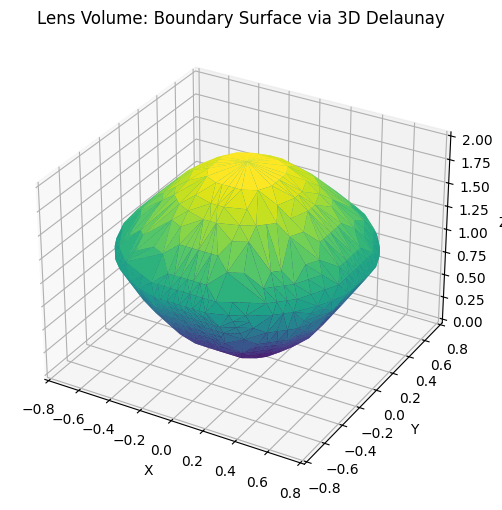

In [12]:
#!/usr/bin/env python

from collections import Counter
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def surface1(x, y):
    """
    surface1(x, y) = 2*x^2 + 2*y^2
    (Paraboloid-like surface)
    """
    return 2*x**2 + 2*y**2

def surface2(x, y):
    """
    surface2(x, y) = 2 * exp(-x^2 - y^2)
    (Gaussian 'cap')
    """
    return 2*np.exp(-x**2 - y**2)

def main():
    # 1) Generate a 3D grid of points
    x_vals = np.linspace(-1, 1, 51)   # 51 steps in x
    y_vals = np.linspace(-1, 1, 51)   # 51 steps in y
    z_vals = np.linspace(0, 2, 21)    # 21 steps in z
    X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)

    # 2) Keep points where surface1(x,y) <= z <= surface2(x,y)
    #    This defines the "lens" region in 3D
    inside_mask = (surface1(X, Y) <= Z) & (Z <= surface2(X, Y))
    X_in = X[inside_mask]
    Y_in = Y[inside_mask]
    Z_in = Z[inside_mask]

    # 3) 3D Delaunay triangulation of the in-volume points
    #    'points_3d' is shape (N,3)
    points_3d = np.column_stack([X_in, Y_in, Z_in])
    tetrahedra = Delaunay(points_3d).simplices

    # 4) Count each triangular face among the tetrahedra
    #    A tetrahedron has 4 faces => each face is a combination of 3 of its 4 vertices
    #    If a face is shared by 2 tetrahedra => interior face
    #    If a face is shared by 1 tetrahedron => boundary face
    from itertools import combinations
    face_counter = Counter()
    for tet in tetrahedra:
        # Sort the 4 vertex indices so combinations are consistent
        tet_sorted = sorted(tet)
        # All 3-combinations => the 4 faces
        for face in combinations(tet_sorted, 3):
            face_counter[face] += 1

    # Extract boundary faces (count == 1)
    boundary_faces = [face for face, count in face_counter.items() if count == 1]

    # 5) Plot the boundary surface
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,6))
    ax.plot_trisurf(X_in, Y_in, Z_in,
                    triangles=boundary_faces,
                    cmap=cm.viridis,
                    edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lens Volume: Boundary Surface via 3D Delaunay')
    plt.show()

if __name__ == "__main__":
    main()


1. d

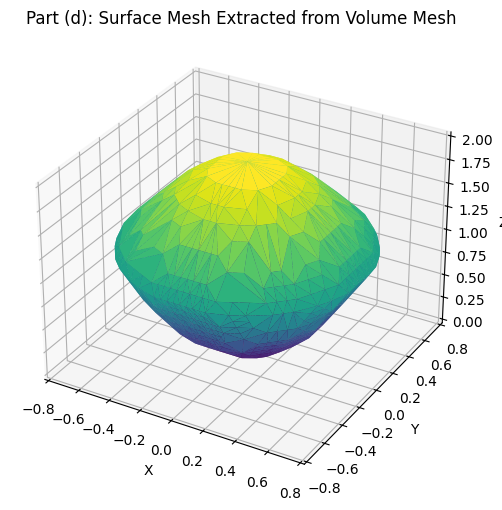

Boundary triangles are shared by exactly 1 tetrahedron. Interior triangles are shared by 2.

Difference between (a)/(b) and (d):
- (a)/(b) focus on 2D triangulation of the surfaces directly (Graham Scan, Jarvis March, etc. in 2D).
- (d) uses a 3D Delaunay volume mesh and then extracts the outer boundary.
  This yields a single closed surface from the tetrahedra that fill the lens volume.



In [14]:

from collections import Counter
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import combinations

def surface1(x, y):
   
    return 2*x**2 + 2*y**2

def surface2(x, y):
   
    return 2*np.exp(-x**2 - y**2)

def main():
  
    x_vals = np.linspace(-1, 1, 51)   # 51 steps in x
    y_vals = np.linspace(-1, 1, 51)   # 51 steps in y
    z_vals = np.linspace(0, 2, 21)    # 21 steps in z
    X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)

    # Keep points where surface1 <= z <= surface2
    in_lens = (surface1(X, Y) <= Z) & (Z <= surface2(X, Y))
    X_in = X[in_lens]
    Y_in = Y[in_lens]
    Z_in = Z[in_lens]

    # 3D Delaunay on points in volume
    points_3d = np.column_stack([X_in, Y_in, Z_in])
    tetrahedra = Delaunay(points_3d).simplices

 
    face_counter = Counter()
    for tet in tetrahedra:
        # Each tetrahedron has 4 triangular faces => combinations of 3 of its 4 vertices
        tet_sorted = sorted(tet)
        for face in combinations(tet_sorted, 3):
            face_counter[face] += 1

    boundary_faces = [face for face, count in face_counter.items() if count == 1]

    # 5) Plot the boundary surface using plot_trisurf
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,6))
    ax.plot_trisurf(X_in, Y_in, Z_in,
                    triangles=boundary_faces,
                    cmap=cm.viridis,
                    edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Part (d): Surface Mesh Extracted from Volume Mesh')
    plt.show()

   
    
    print("Boundary triangles are shared by exactly 1 tetrahedron. Interior triangles are shared by 2.")

    conclusion_text = """
Difference between (a)/(b) and (d):
- (a)/(b) focus on 2D triangulation of the surfaces directly (Graham Scan, Jarvis March, etc. in 2D).
- (d) uses a 3D Delaunay volume mesh and then extracts the outer boundary.
  This yields a single closed surface from the tetrahedra that fill the lens volume.
"""
    print(conclusion_text)

if __name__ == "__main__":
    main()
